# Infer ***mitochondria*** - part 3️⃣

--------------

## OVERVIEW
In notebooks 2-7, we will go how each organelle is segmented. These segmentation workflows are completely independent of each other and can be run in any order. Additionally, the entire image will be processed in this notebook, irrespective of the single cells identified in notebook 1. The cell mask will be applied to the organelle segmentation outputs before quantification (as outlined in [11_regionprops](./11_regionprops.ipynb)). 

This notebook goes through the workflow steps to segment the ***mitochondria*** -- one of the six organelles of interest.

## OBJECTIVE: ✅ Infer sub-cellular component  ***mitochondria***  
Segment the ***mitochondria*** from a single channel (inter mitochondrial membrane marker). This workflow was optimized for images of fluorescently tagged COX8 signal sequence which localizes to the inner mitochondrial membrane. Mitochondria size and shape can range from long filaments to small spheres depending on the cell state and stress levels therefor, we are utilizing two segmentation methods to idenfity all mitochondria.

### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

from typing import Optional, Dict

import numpy as np

from aicssegmentation.core.utils import size_filter
from aicssegmentation.core.MO_threshold import MO

from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari
### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image, 
                                         read_ome_image,
                                         list_image_files, 
                                         import_inferred_organelle, 
                                         export_inferred_organelle)

from infer_subc.core.img import *
from infer_subc.organelles import fixed_infer_cellmask_fromcomposite, fixed_infer_nuclei_fromlabel, get_cytoplasm, get_nuclei, get_cellmask
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )  

%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) /  "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


---------------------
## infer ***mitochondria***
### summary of steps

➡️ EXTRACTION
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the mitochondria marker (channel number = user input)

PRE-PROCESSING
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

CORE PROCESSING
- **`STEP 3`** - ‘Dot’ thresholding method (AICSSeg)

  - apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

- **`STEP 4`** - ‘Filament’ threshold method (AICSSeg)

  - apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`STEP 5`** - Combine Segmentations (logical or)

  - combine the two segmentations with logical *OR*

POST-PROCESSING
- **`STEP 6`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

POST-POST-PROCESSING
- **`STEP 7`** - Label objects

    - label unique mitochondria objects based on connectivity


EXPORT  ➡️
- save labeled ***mitochondria*** (mito, MT) as unsigned integer 16-bit tif files


> Generally following the Allen Cell Segmenter procedure for segmentation of mitochondria from the [Tomm20](https://www.allencell.org/cell-observations/category/tom20) marker, but we also added in an additional segmentation step to include "dots" (also from [AICSSegmentation Package](https://github.com/AllenCell/aics-segmentation/tree/main)). Sourced from: this [script](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_tomm20.py).

# ***EXTRACTION prototype - mito***

## **`STEP 1` - Select a channel for segmentation**

- select single channel containing the mitochondria marker (channel number = user input)

In [4]:
###################
# INPUT
###################
raw_mito = select_channel_from_raw(img_data, MITO_CH)

# ***PRE-PROCESSING prototype - mito***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

In [5]:
###################
# PRE_PROCESSING
###################
med_filter_size = 3
gaussian_smoothing_sigma = 1.34

struct_img =  scale_and_smooth(raw_mito,
                               median_size = med_filter_size, 
                               gauss_sigma = gaussian_smoothing_sigma)

# ***CORE-PROCESSING prototype - mito***

## **`STEP 3` -  ‘Dot’ thresholding method (AICSSeg)**

- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

In [6]:
###################
# CORE_PROCESSING
###################
dot_scale_1 = 1.5
dot_cut_1 = 0.05

dot_scale_2 = 0
dot_cut_2 = 0

dot_scale_3 = 0
dot_cut_3 = 0

dot_method = "3D"

# apply the 2D or 3D versions of the AICSsegmentation dot filter with multiple scales
bw_dot_test = dot_filter_3(struct_img,
                           dot_scale_1,
                           dot_cut_1,
                           dot_scale_2,
                           dot_cut_2,
                           dot_scale_3,
                           dot_cut_3,
                           dot_method)

## **`STEP 4` - ‘Filament’ threshold method (AICSSeg)**

- apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

In [ ]:

fil_scale_1 = 1
fil_cut_1 = 0.15

fil_scale_2 = 0
fil_cut_2 = 0

fil_scale_3 = 0
fil_cut_3 = 0

fil_method = "3D"

# apply the 2D or 3D versions of the AICSsegmentation filament filter with multiple scales
bw_filament_test = filament_filter_3(struct_img,
                                    fil_scale_1,
                                    fil_cut_1,
                                    fil_scale_2,
                                    fil_cut_2,
                                    fil_scale_3,
                                    fil_cut_3,
                                    fil_method)

## **`STEP 5` - Combine Segmentations (logical or)**

- combine the two segmentations with logical *OR*

In [ ]:
# combine the two segmentations together
bw_test = np.logical_or(bw_dot_test, bw_filament_test)

# ***POST-PROCESSING prototype - mito***

## **`STEP 6` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method (method = user input)

In [7]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 3

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# ***POST-POST-PROCESSING prototype - mito***

## **`STEP 7` - Label objects**

- label unique mitochondria objects based on connectivity

In [8]:
###################
# LABELING
###################
mitochondria_labels = label_uint16(cleaned_img2)

In [9]:
mitochondria_labels.dtype

dtype('uint16')

## Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()

31-May-23 11:44:54 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x686+1627+1061 (frame: 1108x733+1618+1023) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1365x859+1628+1068 (frame: 1383x906+1619+1030) margins: 9, 38, 9, 9 minimum size: 612x589 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,636 maxtrack=0,0)


In [11]:
viewer.add_image(
    struct_img)

viewer.add_image(
    cleaned_img2,
    opacity=0.3,)

viewer.add_labels(
    mitochondria_labels,
    opacity=0.3)

<Labels layer 'mitochondria_labels' at 0x1dcd62691b0>

# ***EXTRACTION prototype - mito***

- save labeled ***mitochondria*** (mito, MT) as unsigned integer 16-bit tif files

In [12]:
out_file_n = export_inferred_organelle(mitochondria_labels, "mito", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-mito


# **Define `_infer_mito` function**

Based on the _prototyping_ above define the function to infer the mitochondria.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
#  infer_mito
##########################
def _infer_mito(
                in_img: np.ndarray,
                mito_ch: int,
                median_sz: int,
                gauss_sig: float,
                dot_scale_1: float,
                dot_cut_1: float,
                dot_scale_2: float,
                dot_cut_2: float,
                dot_scale_3: float,
                dot_cut_3: float,
                dot_method: str,
                fil_scale_1: float,
                fil_cut_1: float,
                fil_scale_2: float, 
                fil_cut_2: float, 
                fil_scale_3: float, 
                fil_cut_3: float,
                fil_method: str,
                min_hole_w: int,
                max_hole_w: int,
                small_obj_w: int,
                fill_filter_method: str
                ) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input.

    Parameters
    ------------
    in_img:
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    vesselness_scale: 
        scale (log_sigma) for vesselness filter
    vesselness_cut: 
        threshold for vesselness fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    mito_object
        mask defined extent of mitochondria object
    
    """

    ###################
    # EXTRACT
    ###################    
    mito = select_channel_from_raw(in_img, mito_ch)
    
    ###################
    # PRE_PROCESSING
    ###################                         
    mito =  scale_and_smooth(mito,
                             median_size = median_sz, 
                             gauss_sigma = gauss_sig)
    ###################   
    # CORE_PROCESSING
    ###################
    bw_dot = dot_filter_3(mito, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw_filament = filament_filter_3(mito, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    bw = np.logical_or(bw_dot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1

In [2]:
# ##########################
# #  fixed_infer_mito
# ##########################
# def _fixed_infer_mito(in_img: np.ndarray ) -> np.ndarray:
#     """
#     Procedure to infer mitochondria from linearly unmixed input,
    
#     Parameters
#     ------------
#     in_img: 
#         a 3d image containing all the channels

#     Returns
#     -------------
#     mito_object
#         mask defined extent of mitochondria
#     """
#     mito_ch = 2
#     median_sz = 3
#     gauss_sig = 1.34
#     dot_scale_1 = 1.5
#     dot_cut_1 = 0.05
#     dot_scale_2 = 0
#     dot_cut_2 = 0
#     dot_scale_3 = 0
#     dot_cut_3 = 0
#     dot_method = "3D"
#     fil_scale_1 = 1
#     fil_cut_1 = 0.15
#     fil_scale_2 = 0
#     fil_cut_2 = 0
#     fil_scale_3 = 0
#     fil_cut_3 = 0
#     fil_method = "3D"
#     min_hole_w = 0
#     max_hole_w = 0
#     small_obj_w = 3
#     method = "3D"

#     return _infer_mito(  
#         in_img,
#         mito_ch,
#         median_sz,
#         gauss_sig,
#         dot_scale_1,
#         dot_cut_1,
#         dot_scale_2,
#         dot_cut_2,
#         dot_scale_3,
#         dot_cut_3,
#         dot_method,
#         fil_scale_1,
#         fil_cut_1,
#         fil_scale_2,
#         fil_cut_2,
#         fil_scale_3,
#         fil_cut_3,
#         fil_method,
#         min_hole_w,
#         max_hole_w,
#         small_obj_w,
#         method)



# **Test `_infer_mito` function**

In [15]:
_mito_object =  _infer_mito(  
        img_data,
        MITO_CH,
        med_filter_size,
        gaussian_smoothing_sigma,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2,
        dot_scale_3,
        dot_cut_3,
        dot_method,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method) 

_mito_object.dtype

dtype('uint16')

In [16]:
np.all(mitochondria_labels == _mito_object)

True

In [17]:
# from infer_subc.organelles import fixed_infer_mito

# mito_object =  fixed_infer_mito(img_data)

In [18]:
# np.all(_mito_object == mito_object)

True

## Visualize  2


In [19]:
viewer.add_image(
    _mito_object,
    opacity=0.3)

viewer.add_labels(
    mito_object,
    opacity=0.3)

<Labels layer 'mito_object' at 0x1dccc637910>

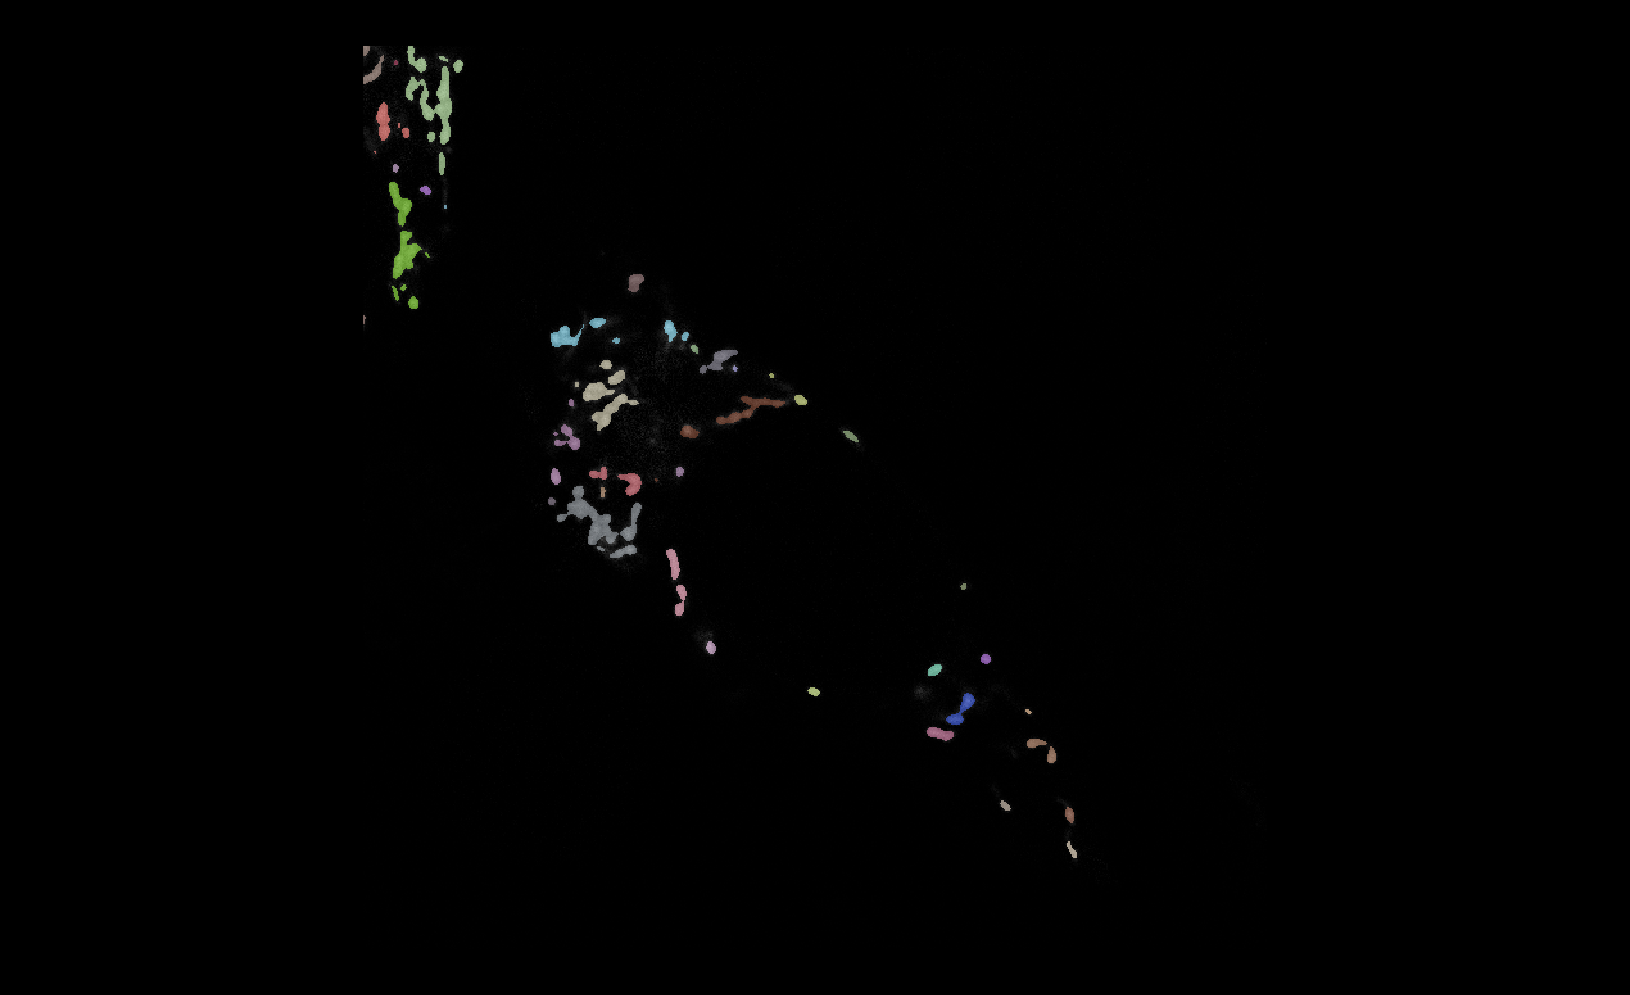

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## **SUMMARY**

The above details how the mitochondria object is inferred.  

### NEXT: INFER GOLGI

proceed to [04_infer_golgi.ipynb](./04_infer_golgi.ipynb)
